# Trabajo práctico
Convinando las técnicas descriptas anteriormente, implemente una CNN para el problema [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html). Objetivos en el conjunto de validación:
* accuracy > 0.3.
* top-5 accuracy > 0.6.

**NOTA:** No es necesario que su solución utilice todas las técnicas descriptas.

### Opcional
Intente implementar otra solución utilizando módulos fire que se describen en la arquitectura [SqueezeNet](https://arxiv.org/abs/1602.07360).

## Requerimientos:


1.   El notebook debe correr linealmente.
2.   Debe entregarse con las salidas ejecutadas.
3.   Debe incluirse una pequeña explicación antes de cada arquitectura probada.
4.   Debe incluirse una conclusión al final del trabajo.



Importamos todas las librerias que vamos a necesitar en el desarrollo del trabajo.

In [ ]:
#Imports
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

Se nos dio el codigo para levantar el Cifar-100 directamente desde tensorflorw.
Normalizamos para que las imagenes se encuentren en un rango de 0 a 1, ya que esto es necesario para el gradiente desendente.

In [ ]:
#Levanta el cifar-100
from tensorflow.keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#Normalizacion: 
x_train = x_train/255
x_test = x_test/255

169009152/169001437 [==============================] - 2s 0us/step


Comence armando una red con lo aprendido en clase, generando una red CNN de la siguiente manera:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               295040    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               1

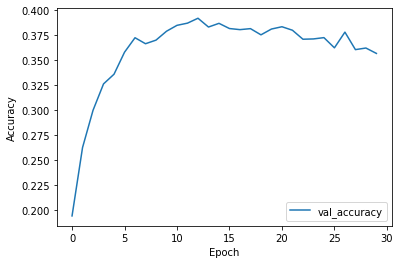

In [ ]:
#MODELO 1

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras import models
import tensorflow as tf

modelo = models.Sequential()

# Primera capa
modelo.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)))
modelo.add(MaxPooling2D(pool_size=(2,2)))

# Segunda capa
modelo.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))

# Aplanar, Capas densas y salida.
modelo.add(Flatten())
modelo.add(Dense(128,activation='relu'))
modelo.add(Dense(100,activation='softmax'))

#modelo = Model(inputs=i, outputs=d)
modelo.summary()
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy','top_k_categorical_accuracy'])

#batch_size 100 con 64, 64, 128 -> 0.3757 es mas estable tambien

history = modelo.fit(x_train, y_train, epochs=30, batch_size=100, verbose=2, validation_data=(x_test, y_test))
test_acc = modelo.evaluate(x_test,  y_test, verbose=2)

plt.plot(history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

print()
print(modelo.evaluate(x_test,y_test))

La red cuenta con en primera instancia un modelo secuencial ya que vamos a armar una red CNN. En la primera capa le agrege **Conv2D** con 64 filtros entonces en una imagen de entrada de 32x32x3 y un kernel de 3x3 se estiraría cada campo en un vector de largo 27, y se ejecutarían 32 x 32 =1024 convoluciones, y le aplicamos la funcion de activacion 'Relu' que es la más común en las redes neuronales convolucionales que básicamente impide que valores negativos se propaguen por la red, ademas se agrego **Maxpooling** ya que usa para requerir un 75% menos de parámetros y propaga solo las mejores características. Lo explicado anterior se agrego dos veces.
Despues llegamos a la etapa de 'aplanado' la cual es **Flatten** convierte los elementos de la matriz de imagenes de entrada en un array plano; agregamos una **capa densa** de 128 filtros con una funcion de activacion 'Relu' y como ultima capa, se agrego una **densa** de 100 que son las clases del Cifar-100 con una funcion de activacion 'Softmax' para transformar las salidas a una representación en forma de probabilidades, de tal manera que el sumatorio de todas las probabilidades de las salidas, esta acotada entre 0 y 1.

La red presentada aca arriba fue la primera que hice, el modelo alcanza una precisión de 67.77% para el set de entrenamiento y del 35.68% para el set de validación. 
Particularmente no me sentia satisfecho con el resultado, ya que se ve claramente que en set de validacion cae con el tiempo. Por ende me di la tarea de tratar de mejorarla.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                147520    
_________________________________________________________________
dense_15 (Dense)             (None, 100)              

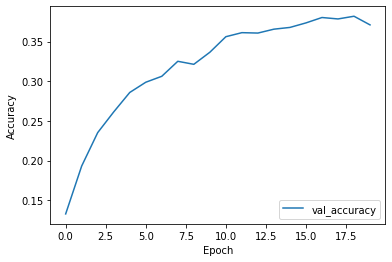

In [ ]:
#MODELO 2

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras import models
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization

modelo1 = models.Sequential()

# Añadimos la primera capa
modelo1.add(Conv2D(64,(3,3), activation = 'relu', input_shape = (32,32,3)))
modelo1.add(MaxPooling2D(pool_size = (2,2)))

# Añadimos la segunda capa
modelo1.add(Conv2D(64,(3,3), activation = 'relu'))
modelo1.add(MaxPooling2D(pool_size = (2,2)))

# Hacemos un flatten para poder usar una red fully connected
modelo1.add(Flatten())
modelo1.add(Dense(64, activation='relu'))

# Añadimos una capa softmax para que podamos clasificar las imágenes
modelo1.add(Dense(100, activation='softmax'))


modelo1.summary()
modelo1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy','top_k_categorical_accuracy'])


history = modelo1.fit(x_train, y_train, epochs=20, batch_size=200, verbose=1, validation_data=(x_test, y_test))
test_acc = modelo1.evaluate(x_test,  y_test, verbose=2)

plt.plot(history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

print()
print(modelo1.evaluate(x_test,y_test))

En esta red de arriba vemos que es muy parecida pero al cambiar algunos parametros note que mejoro un poco en en el valor de verificacion pero empeoro muchisimo el de entrenamiento, consiguiendo:
una precisión de 45.23% para el set de entrenamiento y del 37.10% para el set de validación. 
Tampoco me quede satisfecho con esta solucion, por ende segui buscando.

Me di la tarea de buscar redes neuronales que tengan que ver con imagenes, tratando de conseguir alguna que haga algo parecido a lo que yo estoy buscando.
Entonces en mi busqueda encontre dos que me interesaron bastante y trate de amoldar esa red a la mia.
* Red neuronal sobre deteccion de objetos, en esta red detectaba muñecos de legos en vivo. Info: https://www.aprendemachinelearning.com/deteccion-de-objetos-con-python-yolo-keras-tutorial/
* Red neuronal sobre reconocimientos de imagenes. Info: https://towardsdatascience.com/image-recognition-with-machine-learning-on-python-convolutional-neural-network-363073020588



Entonces arme la siguiente red mucho mas grande que las anteriores que tiene en la primera capa, dos **Conv2D** con 128 filtros los dos y la funcion de activacion es la 'Relu' igual que la anterior red, en este le agregamos el padding 'same', ademas agregamos **AveragePooling2D** que en la anterior red usamos Maxpooling, con el Average conseguimos que se seleccione el valor medio de todos los píxeles del lote en ves de el valor de píxel máximo del lote, tambien agregamos un **dropout** que por cada nueva entrada a la red en la fase de entrenamiento, se desactivará aleatoriamente un porcentaje de las neuronas en cada capa oculta, acorde a una probabilidad de descarte previamente definida, esto ayude a que la red no "memorice". La segunda y tercera capa son iguales, solo que fui alterando los valores para tratar de conseguir un valor mas alto de aprendizaje y de valoracion. En la cuarta capa aplanamos y agregamos una capa densa con 1024 filtros con la funcion de activacion 'Relu', un dropout y una capa densa con 'Softmax' para el final.

In [ ]:
#MODELO 3

from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU

i = Input(shape=(x_train.shape[1],x_train.shape[2],3))

#Añadimos la primera capa
d = Conv2D(128,(3,3),activation='relu', padding='same')(i)
d = Conv2D(128,(3,3),activation='relu', padding='same')(d)
d = AveragePooling2D(pool_size=(2, 2))(d)
d = Dropout(0.2)(d)

#Añadimos la segunda capa
d = Conv2D(256, (3,3), activation='relu', padding='same')(d)
d = Conv2D(256, (3,3), activation='relu', padding='same')(d)
d = AveragePooling2D(pool_size=(2, 2))(d)
d = Dropout(0.25)(d)

#Añadimos la tercera capa
d = Conv2D(512,(3,3),activation='relu', padding='same')(d)
d = Conv2D(512,(3,3),activation='relu', padding='same')(d)
d = AveragePooling2D(pool_size=(2, 2))(d)
d = Dropout(0.5)(d)

#Aplanamos, y agregamos una capa densa, un dropout y la capa densa de salida.
d = Flatten()(d)
d = Dense(1024, activation='relu')(d)
d = Dropout(0.5)(d)
d = Dense(100, activation='softmax')(d)

model = Model(inputs=i, outputs=d)
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy','top_k_categorical_accuracy'])

model.fit(x_train, y_train, epochs=80, batch_size=650, verbose=1, validation_data=(x_test,y_test))

print()
print(model.evaluate(x_test,y_test))


Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
average_pooling2d_51 (Averag (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 16, 16, 256)     

In [ ]:
#Modelo 3.1
#Alterado de Dropout.
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU

i = Input(shape=(x_train.shape[1],x_train.shape[2],3))

#Añadimos la primera capa
d = Conv2D(128,(3,3),activation='relu', padding='same')(i)
d = Conv2D(128,(3,3),activation='relu', padding='same')(d)
d = AveragePooling2D(pool_size=(2, 2))(d)
d = Dropout(0.2)(d)

#Añadimos la segunda capa
d = Conv2D(256, (3,3), activation='relu', padding='same')(d)
d = Conv2D(256, (3,3), activation='relu', padding='same')(d)
d = AveragePooling2D(pool_size=(2, 2))(d)
d = Dropout(0.25)(d)

#Añadimos la tercera capa
d = Conv2D(512,(3,3),activation='relu', padding='same')(d)
d = Conv2D(512,(3,3),activation='relu', padding='same')(d)
d = AveragePooling2D(pool_size=(2, 2))(d)
d = Dropout(0.8)(d)

#Aplanamos, y agregamos una capa densa, un dropout y la capa densa de salida.
d = Flatten()(d)
d = Dense(1024, activation='relu')(d)
d = Dropout(0.5)(d)
d = Dense(100, activation='softmax')(d)

model = Model(inputs=i, outputs=d)
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy','top_k_categorical_accuracy'])

model.fit(x_train, y_train, epochs=80, batch_size=650, verbose=1, validation_data=(x_test,y_test))

print()
print(model.evaluate(x_test,y_test))

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
average_pooling2d_12 (Averag (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 256)      

Con lo mostrado anteriormente arme la red neuronal de arriba pero es demasiado lenta pero en el **modelo tres** con 80 epochs llegue a conseguir una precisión de 87.40% para el set de entrenamiento y del 57.44% para el set de validación.
Agrege un modelo 3.1 cambiando solo el dropout de la tercera capa de 0.5 a 0.8  llegamos a conseguir una precisión de 76.63% que cayo con respecto al anterior para el set de entrenamiento y del 60.84% para el set de validación. 
Un poco mejor que las anteriores, pero es mucho mas lenta. 

Por ende me quedaria con el modelo 3, ya que el modelo 3.1 perdi 10.77% en el set de entrenamiento y gane nada mas que 3.4% en el set de validacion. 

La anterior a ser muy lenta, trate de armar otra que sea relativamente parecida pero un poco mas rapida.
La presentada a continuacion arrancamos con:
* En la capa uno con una **Conv2D** de 32 filtros con una funcion de activacion 'Relu' como ya veniamos usando, le agrege la función **Leaky ReLU** transforma los valores introducidos multiplicando los negativos por un coeficiente rectificativo y dejando los positivos según entran, tambien agrege una normalizacion **BatchNormalization** que básicamente lo que trate de hacer es añadir un paso extra, habitualmente entre las neuronas y la función de activación, con la idea de normalizar las activaciones de salida, y al final un **AveragePooling** como ya veniamos usando.
* En la capa numero dos, use lo mismo alterando solo la cantidad de filtros a 64 en la Conv2D, y ademas agregar un pool_size en el averagePooling de (2,2).
* En la capa numero tres, use lo mismo tambien alterando la cantidad de filtros a 128 en la conv2D y ademas agregando un pool_size en el averagePooling de (3,3)
* En la capa numero cuatro, use lo mismo tambien pero alterando la cantidad de filtros a 192 en la conv2D y en esta capa saque la normalizacion ya que al sacarla aumentaba considerablemente los valores en la etapa de entrenamiento, y por ende en la etapa de verificacion, por ultimo agregamos un Droup

In [ ]:
#MODELO 4

i = Input(shape=(x_train.shape[1],x_train.shape[2],3))

#Capa 1
d = Conv2D(32,(3,3),activation='relu', strides=(1,1),  name='conv_1')(i)
d = LeakyReLU(alpha=0.3)(d)
d = BatchNormalization(name='norm_1')(d)
d = AveragePooling2D(pool_size=(1,1))(d)

#Capa 2
d = Conv2D(64,(3,3),activation='relu', name='conv_2')(d)
d = LeakyReLU(alpha=0.3)(d)
d = BatchNormalization(name='norm_2')(d)
d = AveragePooling2D(pool_size=(2,2))(d)

#Capa 3
d = Conv2D(128,(3,3),activation='relu', name='conv_3')(d)
d = LeakyReLU(alpha=0.3)(d)
d = BatchNormalization(name='norm_3')(d)
d = AveragePooling2D(pool_size=(3, 3))(d)

#Capa 4
d = Conv2D(192,(3,3),activation='relu',name='conv_4')(d)
d = LeakyReLU(alpha=0.3)(d)
d = AveragePooling2D(pool_size=(2, 2))(d)

#Aplanar
d = Flatten()(d)
d = Dropout(0.1)(d)
#Capa de salida
d = Dense(100,activation='softmax')(d)

model = Model(inputs=i, outputs=d)
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy','top_k_categorical_accuracy'])

model.fit(x_train, y_train, epochs=35, batch_size=645, verbose=1, validation_data=(x_test,y_test))

print()
print(model.evaluate(x_test,y_test))

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 30, 30, 32)        0         
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 30, 30, 32)        128       
_________________________________________________________________
average_pooling2d_23 (Averag (None, 30, 30, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 64)        18496     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 28, 28, 64)      

Considerablemente mas rapida que la anterior, pasamos a 6s en cada epoch y en la anterior estaba en 23s cada epoch, y llegamos a conseguir una precisión de 89.22% para el set de entrenamiento y del 52.88% para el set de validación. Ganamos en precision para el set de entrenamiendo pero perdimos un poco en el porcentaje en la validacion, pero ganamos mucho mas tiempo.

# **Conclusion**

Como conclusion final vimos en lo anterior explicado las distintas alternativas que tenemos, como resumen tenemos:
* **Modelo 1:** El modelo alcanza una precisión de 67.77% para el set de entrenamiento y del 35.68% para el set de validación.
* **Modelo 2:** El modelo alcanza una precisión de 45.23% para el set de entrenamiento y del 37.10% para el set de validación.
* **Modelo 3:** El modelo alcanza una precisión de 87.40% para el set de entrenamiento y del 57.44% para el set de validación.
  * **Modelo 3.1:** El modelo alcanza una precisión de 76.63% para el set de entrenamiento y del 60.84% para el set de validación.
* **Modelo 4:** El modelo alcanza una precisión de 89.22% para el set de entrenamiento y del 52.88% para el set de validación.

Despues de ver y analizar estos cinco modelos, creo que la opcion mas logica seria quedarnos con el modelo 3, ya que nos da una precision del 87.40% para el set de entrenamiento y ademas nos da un 57.44% para el set de validacion, lo malo de esta red es el tiempo que lleva llegar a estos porcentajes, por ejemplo, el modelo 4 lo arme pensando en achichar ese tiempo y obtuve un porcentaje mayor para el set de entrenamiento pero menor en validacion, entonces como para cerrar seria mejor elegir el modelo 3 o modelo 4.

Como para cerrar este trabajo me gustaria decir que pude entender como funciona una red neuronal y poder realizarla, modificar y encarar un problema solo me parecio un reto bastante grande en mi desarrollo personal, definitivamente no llegue a un valor mas alto que el mostrado pero yo creo que con un poco mas de tiempo hubiera llegado un poco mas, ya que a estas fechas entre los demas parciales se complica, pero estoy contento con el resultado final.

# Bibliografia usada:

* https://stackoverflow.com/questions/59749499/how-to-disable-the-warning-tensorflowmethod-on-train-batch-end-is-slow-compa
* https://datasmarts.net/es/como-entrenar-una-red-neuronal-convolucional-cnn-en-cifar-10-con-keras/
* https://github.com/codificandobits/Clasificacion_MNIST_RedesConvolucionales_Keras/blob/master/Clasificacion_de_Digitos_Usando_Redes_Convolucionales_y_Keras.ipynb
* http://oa.upm.es/53050/1/TFG_JAVIER_MARTINEZ_LLAMAS.pdf
* https://github.com/pjreddie/darknet/blob/master/python/darknet.py
* http://opac.pucv.cl/pucv_txt/txt-4000/UCC4151_01.pdf
* https://andrewkruger.github.io/projects/2017-08-05-keras-convolutional-neural-network-for-cifar-100#the-model
* https://www.aprendemachinelearning.com/deteccion-de-objetos-con-python-yolo-keras-tutorial/
* https://towardsdatascience.com/image-recognition-with-machine-learning-on-python-convolutional-neural-network-363073020588
* https://github.com/andrewkruger/cifar100_CNN
* https://hirogosomewhere.com/2020/05/16/cifar100-image-classification/
* https://medium.com/metadatos/t%C3%A9cnicas-de-regularizaci%C3%B3n-b%C3%A1sicas-para-redes-neuronales-b48f396924d4#:~:text=Normalizaci%C3%B3n%20por%20lotes%20(Batch%20normalization)&text=La%20normalizaci%C3%B3n%20en%20lotes%20consiste,normalizar%20las%20activaciones%20de%20salida.
* https://medium.com/@bdhuma/which-pooling-method-is-better-maxpooling-vs-minpooling-vs-average-pooling-95fb03f45a9